# Step 1: Minimal CrossFormer Inference Example

This Colab demonstrates how to load a pre-trained / finetuned CrossFormer checkpoint, run inference for a single-arm and bimanual manipulation system, and compare the outputs to the true actions.

First, let's start with a minimal example!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import datasets
import itertools
from PIL import Image
import io
from crossformer.utils import visualization_utils
from crossformer.model.crossformer_model import CrossFormerModel
import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['CURL_CA_BUNDLE'] = certifi.where()
#import mediapy

2024-11-29 15:21:02.473520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 15:21:02.473588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 15:21:02.475201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 15:21:03.670859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = CrossFormerModel.load_pretrained("hf://rail-berkeley/crossformer")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

2024-11-29 15:22:38.229929: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
#OpenX-Embodiment dataset
dataset_names = ["kuka", "bc_z", "cmu_playing_with_food"]
data_per_dataset = {}
for dataset_name in dataset_names:
    ds = datasets.load_dataset("jxu124/OpenX-Embodiment", dataset_name, streaming=True, split='train', trust_remote_code=True)  # IterDataset
    random_item = next(itertools.islice(ds, 10, 10 + 1))
    data_per_dataset[dataset_name] = random_item

/home/x_jenlu/.conda/envs/crossformer/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


In [4]:
def create_observation(data, WINDOW_SIZE=1):
    img = Image.open(io.BytesIO(data['data.pickle']['steps'][0]['observation']['image']['bytes']))
    img = img.resize((224,224))
    #display(img)
    img = np.asarray(img)
    input_images = np.stack(img)[None,None]
    observation = {
        "image_primary": input_images,
        "timestep_pad_mask": np.full((1, input_images.shape[1]), True, dtype=bool),
    }
    return observation

In [5]:
def create_language_task(instruction, model):
    #print(data['data.pickle']['steps'][0].keys())
    #language_instruction = data['data.pickle']['steps'][0]['language_instruction']
    task = model.create_tasks(texts=[instruction])  # for language conditioned
    return task

In [6]:
def get_attention(variables):
    attention_averaged_per_head = []
    encoder_blocks = variables['intermediates']['crossformer_transformer']['BlockTransformer_0']['Transformer_0'].keys()
    for encoder_block in encoder_blocks:
        attention_weights = variables['intermediates']['crossformer_transformer']['BlockTransformer_0']['Transformer_0'][encoder_block]['MultiHeadDotProductAttention_0']['attention_weights'][0]
        attention_averaged_per_head.append(attention_weights.squeeze().mean(0))
    return attention_averaged_per_head

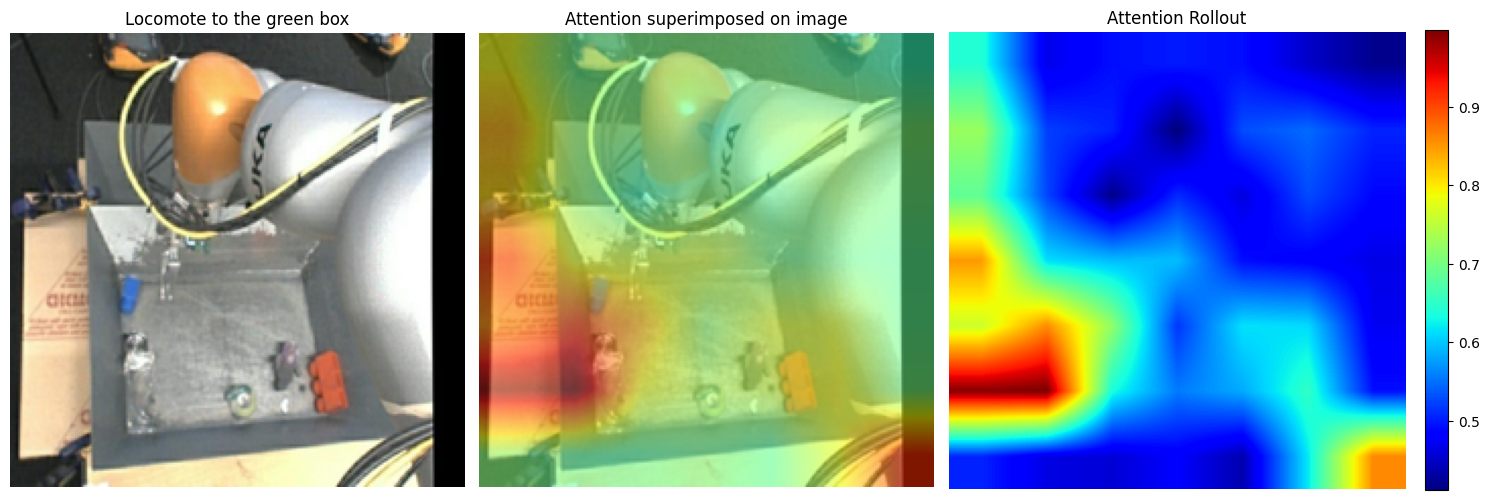

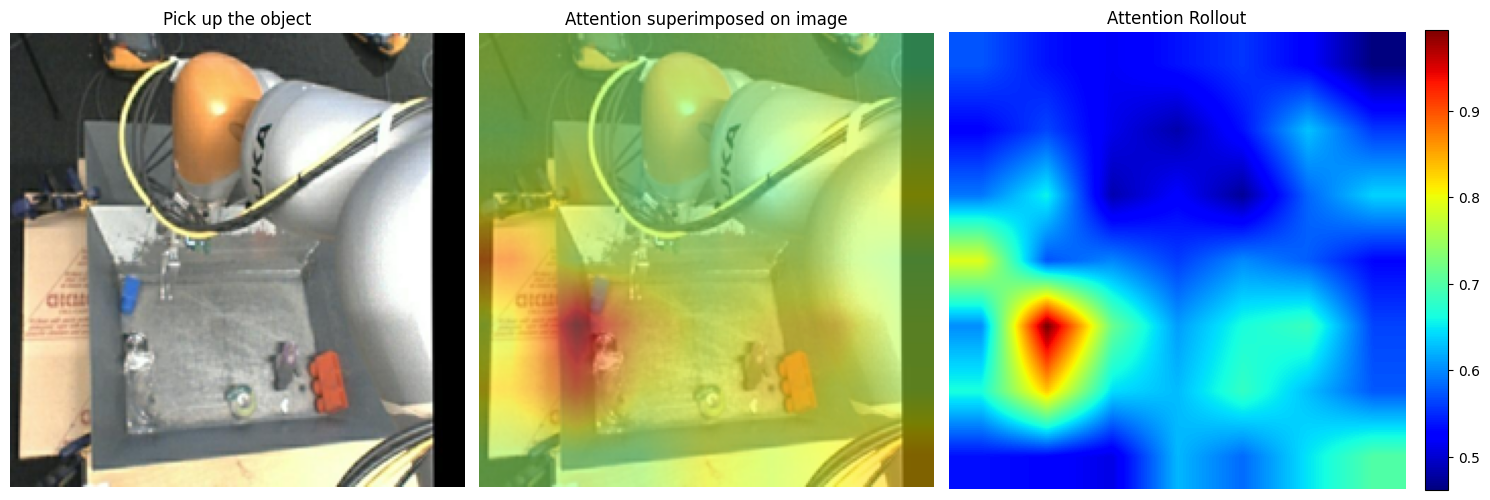

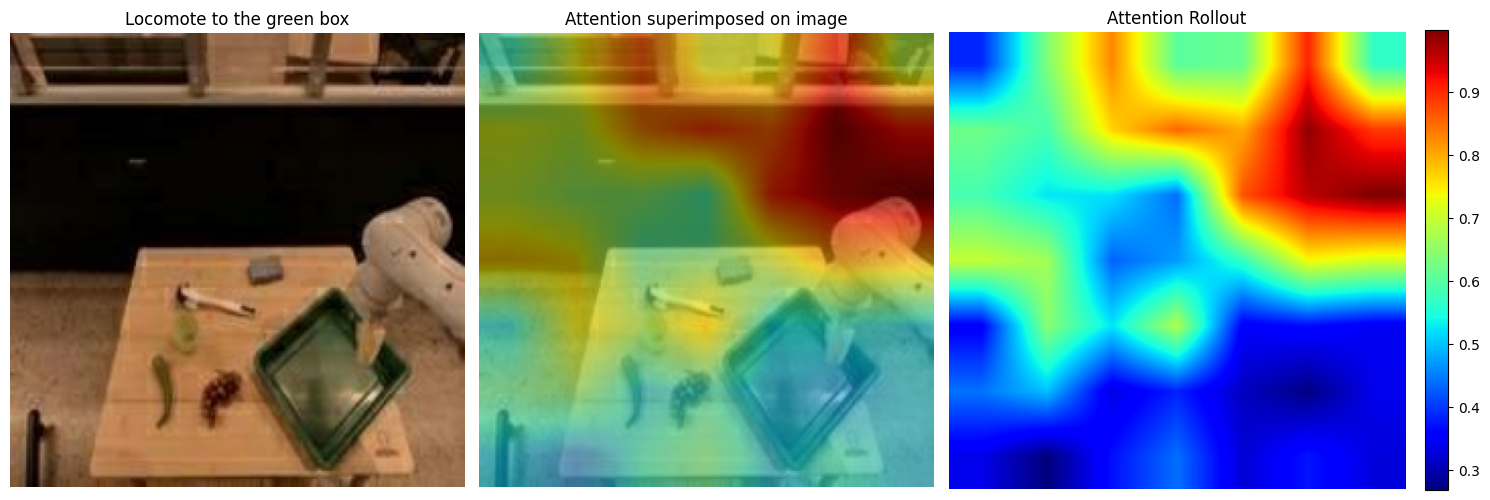

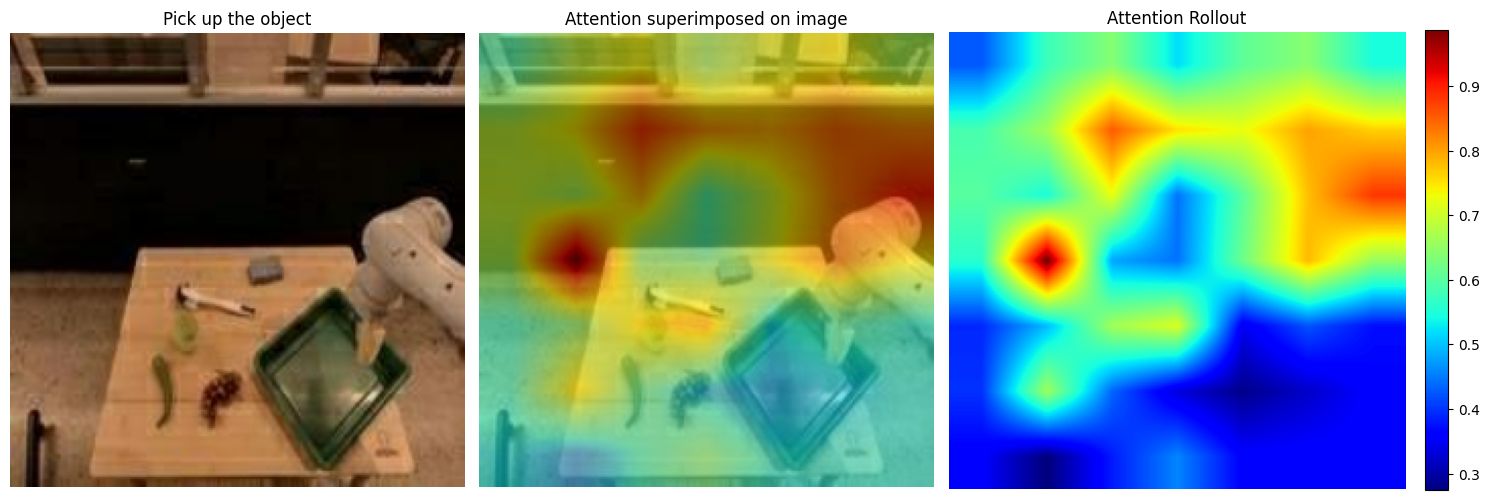

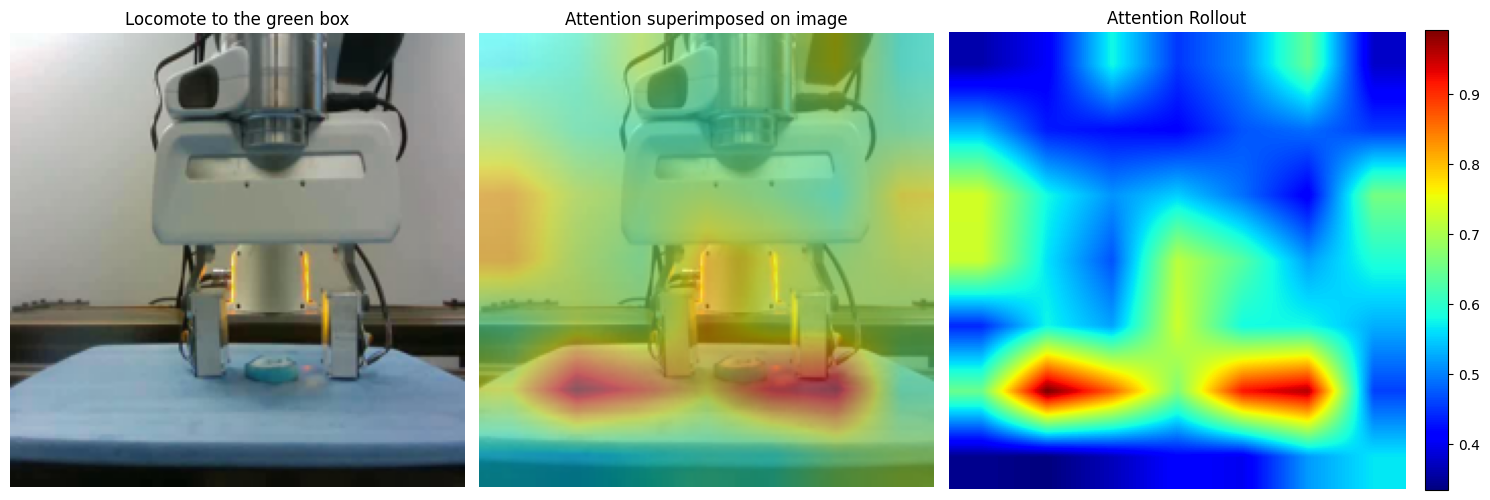

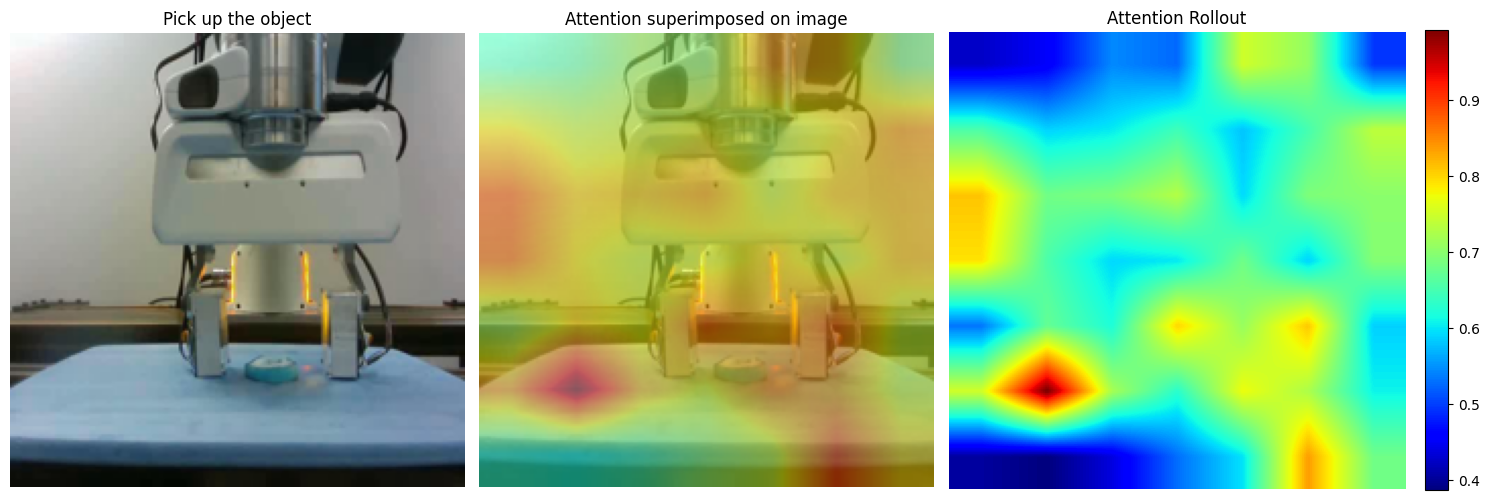

In [13]:
import importlib
importlib.reload(visualization_utils)
negative_transfer_instruction = "Locomote to the green box"
positive_transfer_instruction = "Pick up the object"
negative_transfer_task = create_language_task(negative_transfer_instruction, model)
positive_transfer_task = create_language_task(positive_transfer_instruction, model)
head_fusion = "max"
rollouts_negative_transfer = []
rollouts_positive_transfer = []
outputs_negative_transfer = []
outputs_positive_transfer = []
attentions_per_datapoint_negative_transfer = []
attentions_per_datapoint_positive_transfer = []
for data in data_per_dataset.keys():
    observation = create_observation(data_per_dataset[data])
    negative_transfer_rollout, negative_transfer_token_types, negative_transfer_outputs, negative_transfer_variables = model.analyze_attention(observation, negative_transfer_task, head_fusion=head_fusion)
    positive_transfer_rollout, positive_transfer_token_types, positive_transfer_outputs, positive_transfer_variables = model.analyze_attention(observation, positive_transfer_task, head_fusion=head_fusion)

    attentions_per_datapoint_negative_transfer.append(get_attention(negative_transfer_variables))
    attentions_per_datapoint_positive_transfer.append(get_attention(positive_transfer_variables))
    
    rollouts_negative_transfer.append(negative_transfer_rollout)
    rollouts_positive_transfer.append(positive_transfer_rollout)
    outputs_negative_transfer.append(negative_transfer_outputs['readout_single_arm'].tokens)
    outputs_positive_transfer.append(positive_transfer_outputs['readout_single_arm'].tokens)
    visualization_utils.plot_readout_attention2(negative_transfer_rollout, negative_transfer_token_types, "readout_single_arm", observation, observation_type="_primary", observation_image=observation["image_primary"][0,0], title=negative_transfer_instruction)
    visualization_utils.plot_readout_attention2(positive_transfer_rollout, positive_transfer_token_types, "readout_single_arm", observation, observation_type="_primary", observation_image=observation["image_primary"][0,0], title=positive_transfer_instruction)